In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.ensemble import RandomForestRegressor



In [26]:
df = pd.read_csv('/content/data_sales.csv')
df.head(10)

,date,store,item,sales,f0,f1
0,01-01-2013,1,1,13.0,9.0,NaN
1,02-01-2013,1,1,11.0,NaN,NaN
2,03-01-2013,1,1,14.0,NaN,NaN
3,04-01-2013,1,1,13.0,NaN,NaN
4,05-01-2013,1,1,10.0,NaN,NaN
5,06-01-2013,1,1,12.0,NaN,NaN
6,07-01-2013,1,1,10.0,2.0,NaN
7,08-01-2013,1,1,9.0,3.0,NaN
8,09-01-2013,1,1,12.0,4.0,NaN
9,10-01-2013,1,1,9.0,9.0,NaN


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    913000 non-null  object 
 1   store   913000 non-null  int64  
 2   item    913000 non-null  int64  
 3   sales   912943 non-null  float64
 4   f0      41 non-null      float64
 5   f1      41 non-null      float64
dtypes: float64(3), int64(2), object(1)
memory usage: 41.8+ MB


In [28]:
df.drop(['f0', 'f1'], axis=1, inplace=True)

In [29]:
df.sample(5)

,date,store,item,sales
230171,06-04-2013,7,13,63.0
835321,20-04-2015,8,46,61.0
96468,25-02-2017,3,6,74.0
387290,28-06-2013,3,22,88.0
15870,16-06-2016,9,1,31.0


In [30]:
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

In [31]:
df.describe()

,date,store,item,sales
count,913000,913000.000000,913000.000000,912943.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.251626
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801046


In [32]:
df = df.set_index('date').interpolate()


In [33]:
df = df.reset_index(drop=False)
df.sample(5)

,date,store,item,sales
593538,2013-03-30,6,33,44.0
244706,2013-01-23,5,14,21.0
852673,2017-10-24,7,47,7.0
534926,2017-10-01,3,30,60.0
161700,2015-10-10,9,9,46.0


In [35]:
df.sort_values(by='date', ascending = True, inplace = True)

df = df[df['store'] == 1]
df = df[df['item'] == 1]

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # convert date column to datatime object

# Create Date-related Features to be used for EDA and Supervised ML: Regression
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)

train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13.0,2013,1,1,1
1,2013-01-02,1,1,11.0,2013,1,2,2
2,2013-01-03,1,1,14.0,2013,1,3,3
3,2013-01-04,1,1,13.0,2013,1,4,4
4,2013-01-05,1,1,10.0,2013,1,5,5


##linear regression

In [39]:
for i in range(1,8):
    lag_i = 'lag_' + str(i)
    df[lag_i] = df.sales.shift(i)

# Rolling window
df['rolling_mean'] = df.sales.rolling(window=7).mean()
df['rolling_max'] = df.sales.rolling(window=7).max()
df['rolling_min'] = df.sales.rolling(window=7).min()

df = df.dropna(how='any', inplace=False)
df = df.drop(['store', 'item'], axis=1)

# Split the series to predict the last 3 months of 2017
df = df.set_index('date')
reg_train_df = df.loc[:'2017-09-30']
reg_test_df= df.loc['2017-10-01':]

In [41]:
X_train = reg_train_df.drop(['sales'], axis=1)
y_train = reg_train_df['sales'].values

X_test = reg_test_df.drop(['sales'], axis=1)
y_test = reg_test_df['sales'].values

#Univariate SelectKBest class to extract top 5 best features
top_features = SelectKBest(score_func=f_regression, k=5)
fit = top_features.fit(X_train, y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature','Score']  # naming the dataframe columns
print(feature_scores.nlargest(5,'Score'))

         Feature        Score
11  rolling_mean  1589.228179
12   rolling_max  1178.152819
13   rolling_min   882.979562
10         lag_7   855.292324
4          lag_1   461.537802


<Axes: >

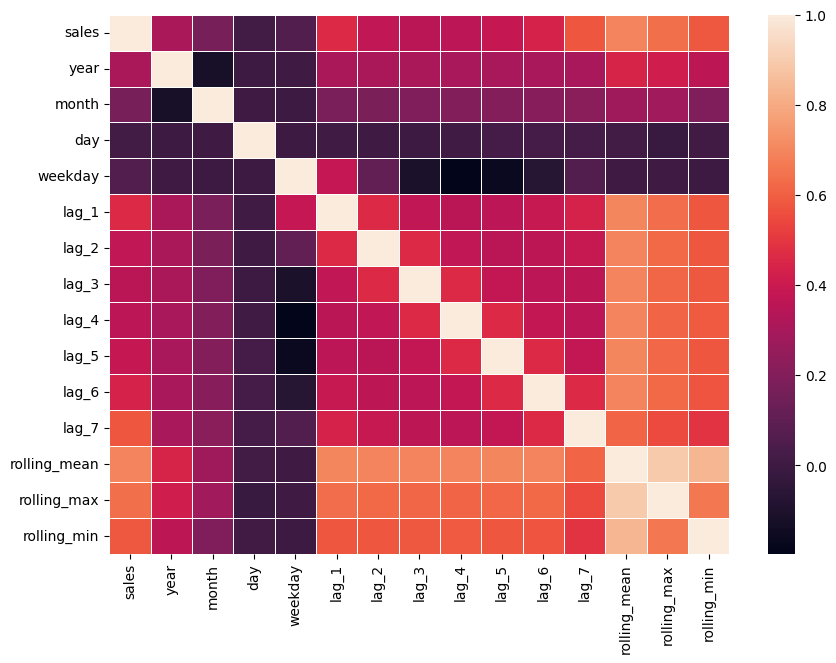

In [40]:
corr = reg_train_df.corr()
fig = plt.figure(figsize=(10,7))
sns.heatmap(corr, linewidths=.5)

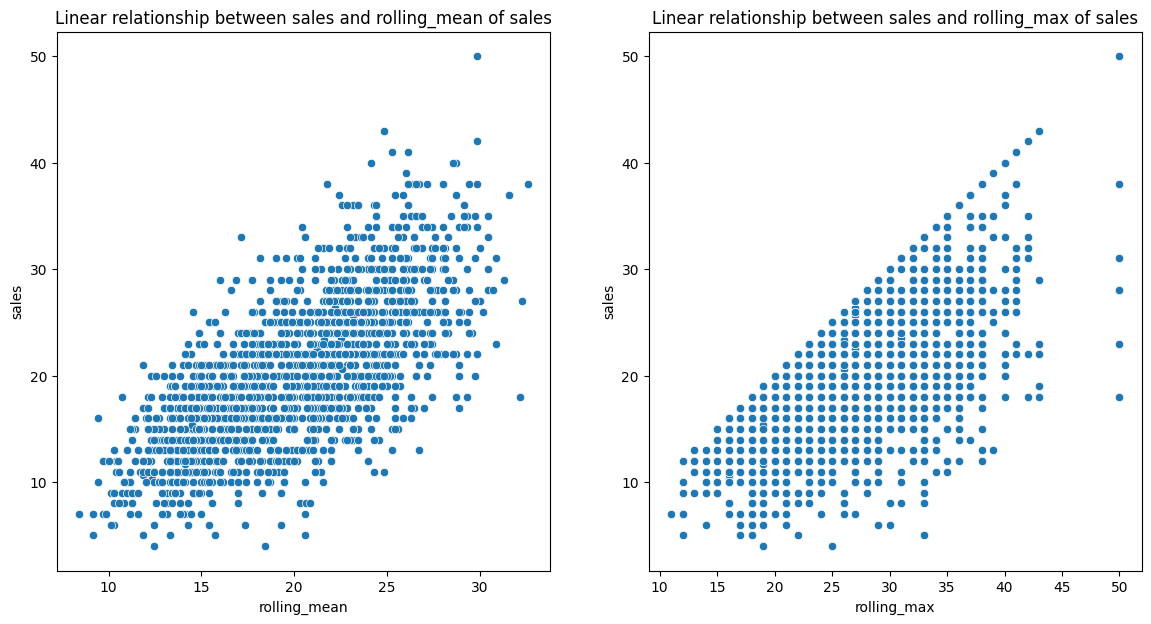

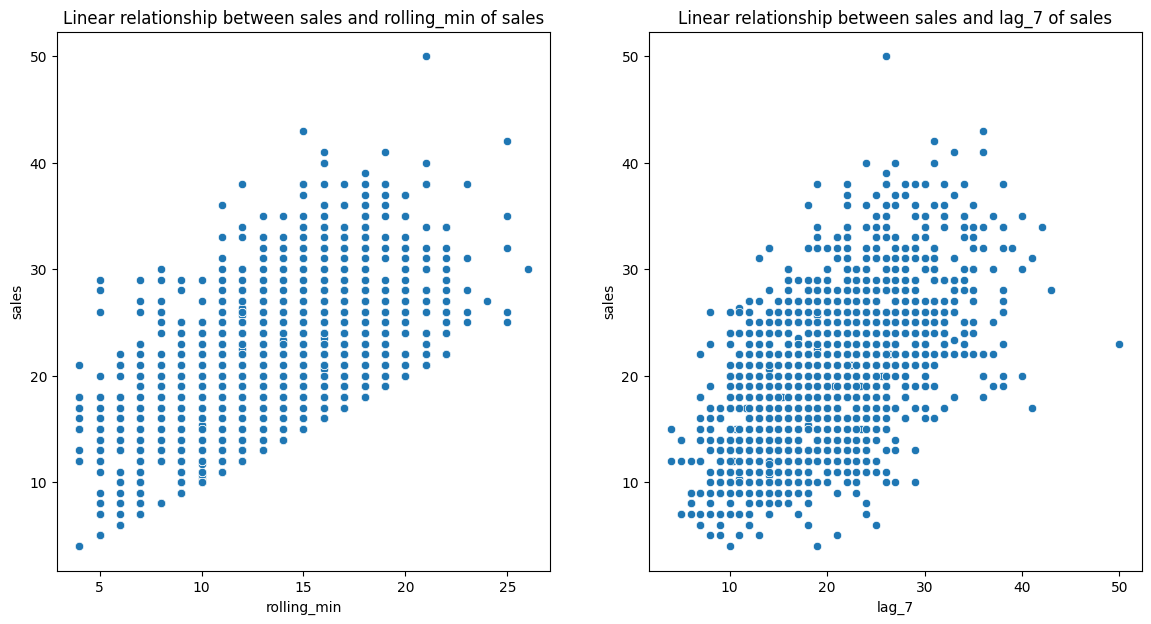

In [42]:
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sns.scatterplot(x=reg_train_df['rolling_mean'], y=reg_train_df['sales'], ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_mean of sales')
sns.scatterplot(x=reg_train_df['rolling_max'], y=reg_train_df['sales'], ax=axs[1])
axs[1].set(title='Linear relationship between sales and rolling_max of sales')

fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sns.scatterplot(x=reg_train_df['rolling_min'], y=reg_train_df['sales'], ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_min of sales')
sns.scatterplot(x=reg_train_df['lag_7'], y=reg_train_df['sales'], ax=axs[1])
axs[1].set(title='Linear relationship between sales and lag_7 of sales')

plt.show()

In [43]:
X_train = X_train[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]
X_test = X_test[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

errors_df = reg_test_df[['sales']]
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
errors_df.insert(0, 'model', 'LinearRegression')

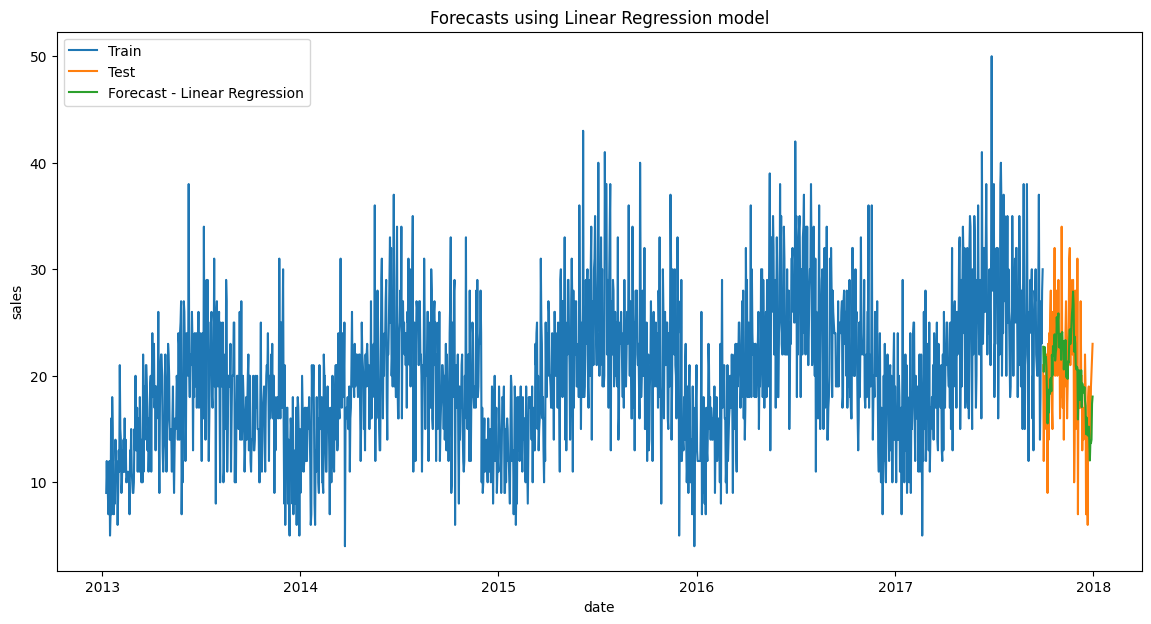

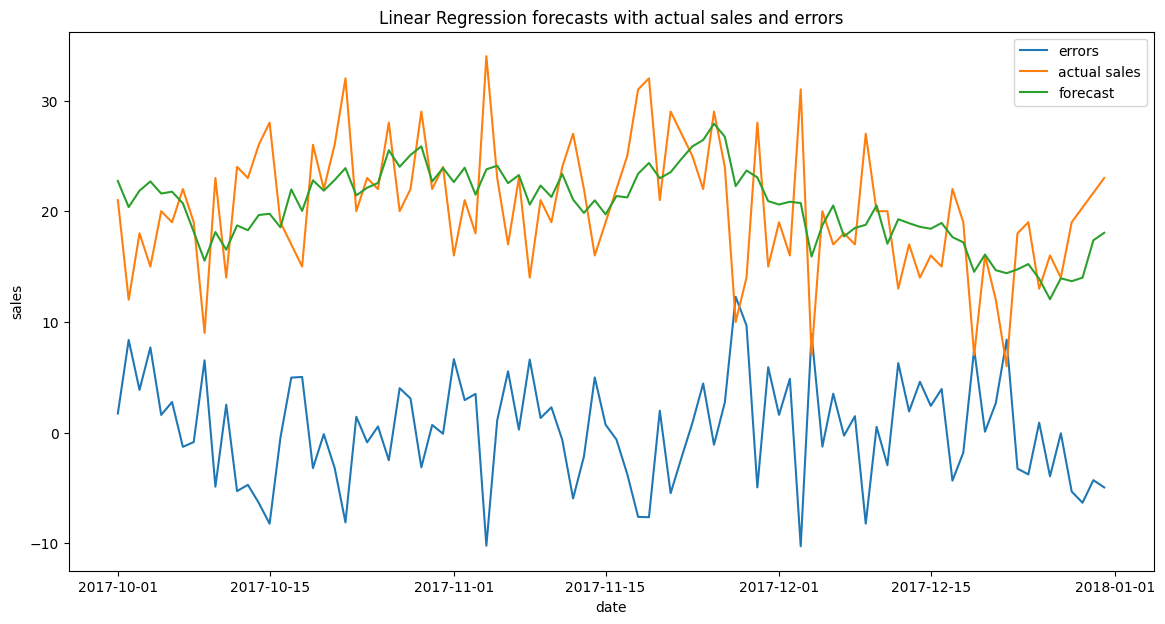

In [44]:
# eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.sales, label='actual sales')
plt.plot(errors_df.index, errors_df.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Linear Regression forecasts with actual sales and errors')
plt.show()


In [62]:
import numpy as np
result_df_lr = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', lambda x: mean_absolute_error(errors_df['sales'], errors_df['pred_sales'])),  # Calculate MAE using lambda
                                          MAPE=('errors', lambda x: mean_absolute_percentage_error(errors_df['sales'], errors_df['pred_sales'])))  # Calculate MAPE using lambda
result_df_lr

,total_sales,total_pred_sales,LR_overall_error,MAE,MAPE
model,,,,,
LinearRegression,1861.0,1877.305833,16.305833,4.084665,0.243351


##Random forest

In [63]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

preds = model_rf.predict(X_test)

errors_df = reg_test_df[['sales']]
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
errors_df.insert(0, 'model', 'RandomForestRegressor')

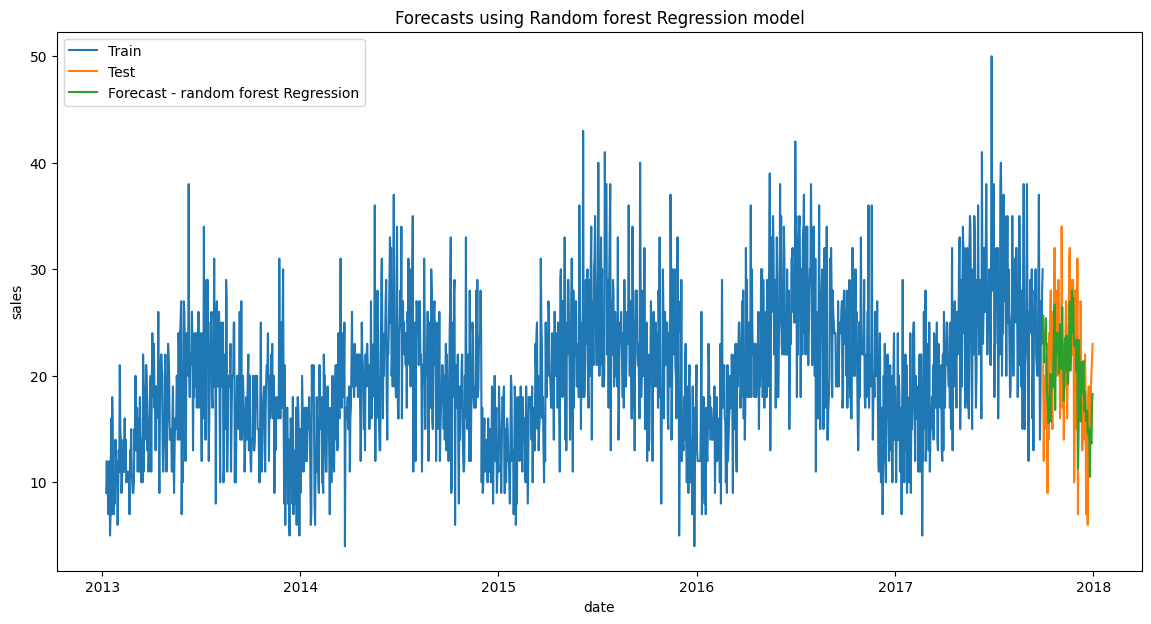

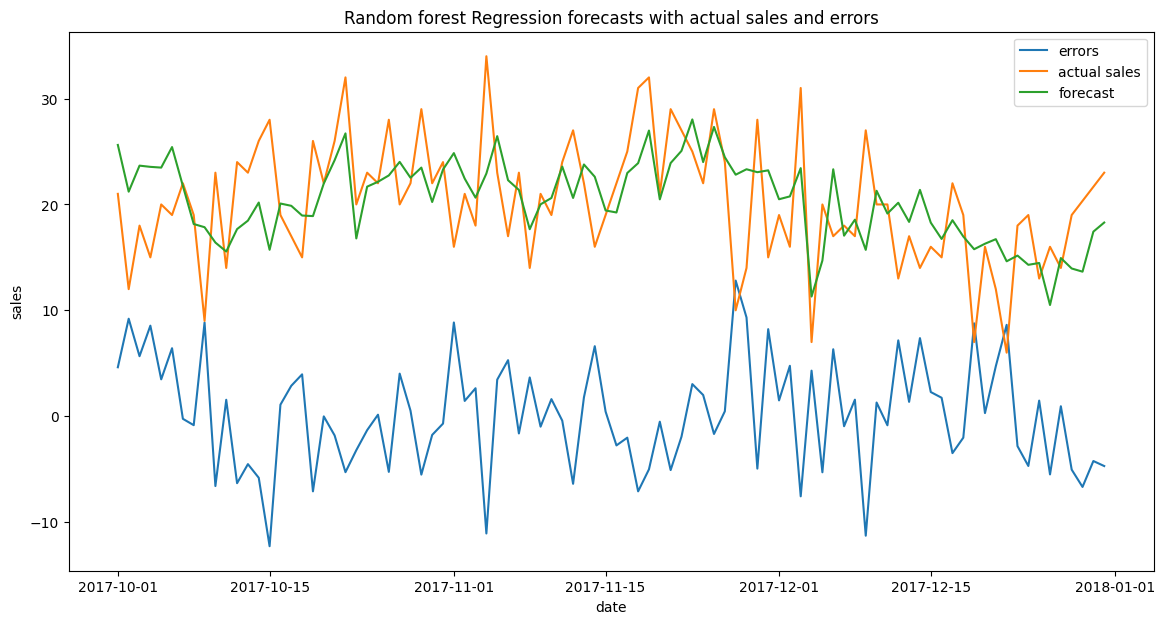

In [64]:
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast - random forest Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Random forest Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.sales, label='actual sales')
plt.plot(errors_df.index, errors_df.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Random forest Regression forecasts with actual sales and errors')
plt.show()

In [66]:
import numpy as np
result_df_rf = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', lambda x: mean_absolute_error(errors_df['sales'], errors_df['pred_sales'])),  # Calculate MAE using lambda
                                          MAPE=('errors', lambda x: mean_absolute_percentage_error(errors_df['sales'], errors_df['pred_sales'])))  # Calculate MAPE using lambda
result_df_rf

,total_sales,total_pred_sales,LR_overall_error,MAE,MAPE
model,,,,,
RandomForestRegressor,1861.0,1872.493333,11.493333,4.157101,0.247218
